# How High can I Get
My attempt at extracting height information from print footage of the 3DPMD DED process.

In [91]:
# importing required packages
from utils import utils
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from myfuncs import funcs
import cv2 as cv
import ffmpeg


## Loading Images

In [92]:
im1 = cv.imread('Images/Inputs/sideview/SIDEVIEW1_20241008-164916506387-0001.png', cv.IMREAD_GRAYSCALE) 
im2 = cv.imread('Images/Inputs/sideview/SIDEVIEW1_20241008-164916506387-0002.png', cv.IMREAD_GRAYSCALE)
im1 = cv.normalize(im1, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
im2 = cv.normalize(im2, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

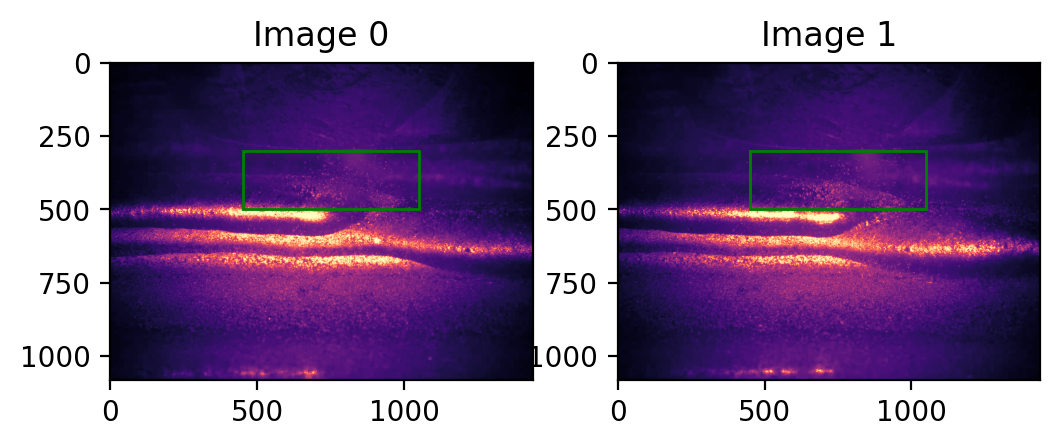

In [93]:
# display images
image_plots = [im1, im2]

fig, axs = plt.subplots(1, 2, figsize=(6,3), dpi=200)
for i, img in enumerate(image_plots):
    axs[i].imshow(img, cmap='magma')
    axs[i].set_title('Image ' + str(i))
    axs[i].add_patch(plt.Rectangle((450,500), 600, -200, edgecolor='green', facecolor='none', lw=1))
    #axs[i].set_axis_off()


In [5]:
def remove_highlights(image, threshold=60, type=cv.THRESH_BINARY):
    _, highlights = cv.threshold(image, threshold, 255, type)
    return highlights


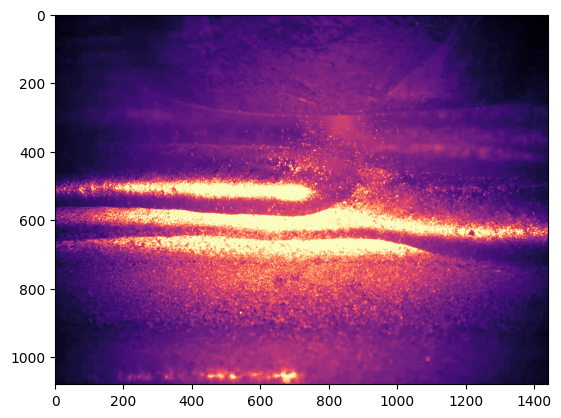

In [94]:
plt.imshow(remove_highlights(im1, threshold=150, type=cv.THRESH_TRUNC), cmap='magma')

Note that for each of the image, the main ROI has a few sub-ROIs:

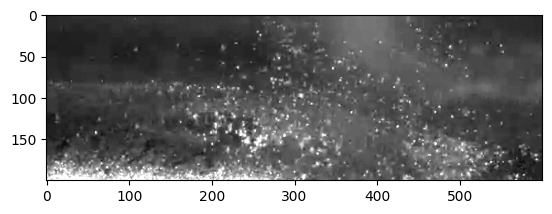

In [7]:
im1_trunc = remove_highlights(im1, threshold=150, type=cv.THRESH_TRUNC)
ROI_1 = im1_trunc[300:500, 450:1050]
plt.imshow(ROI_1, cmap='grey')

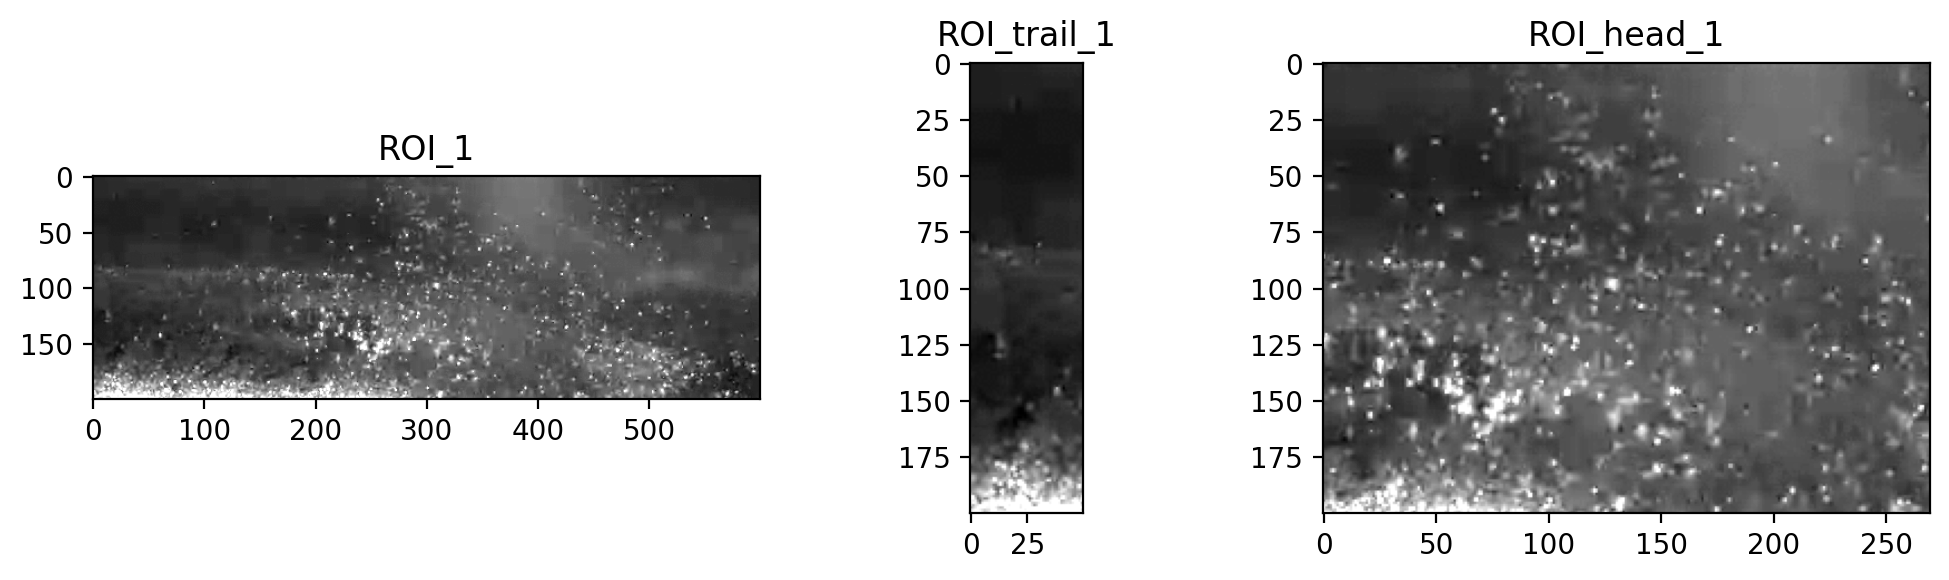

In [18]:
ROI_trail_1 = ROI_1[0:200, 0:50]
ROI_head_1 = ROI_1[0:200, 180:450]

ROI_plots = [ROI_1, ROI_trail_1, ROI_head_1]
titles_plots = ['ROI_1', 'ROI_trail_1', 'ROI_head_1']

# plot the three ROIs
fig, axs = plt.subplots(1, 3, figsize=(10,3), dpi=200)
for i, img in enumerate(ROI_plots):
    axs[i].set_title(titles_plots[i])
    #axs[i].set_axis_off()
    axs[i].imshow(img, cmap='grey')

fig.tight_layout()


## Analysing the trail image

In [50]:
line_from_image = ROI_trail_1[:149, 0]

In [51]:
# define a function to smooth a function using convolutions
def conv_smooth_function(func, window_size=10, scale=False):
    
    func_convolve = np.convolve(func, np.ones(window_size), 'valid')
    func_convolve /= np.max(func_convolve)
    # remove constant
    
    return func_convolve

Text(0.5, 1.0, 'Brightness and Pixels')

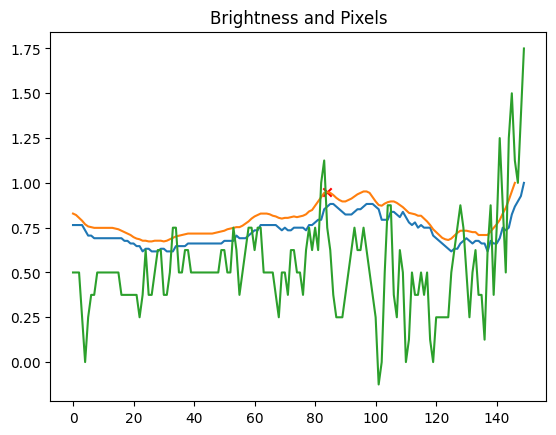

In [98]:
smooth_line = conv_smooth_function(line_from_image, window_size=4)
peak_locations = funcs.peak_finder(smooth_line, num_peaks=1)

plt.plot(line_from_image/np.max(line_from_image), label="Trail")
plt.plot(smooth_line)

plt.scatter(peak_locations, smooth_line[peak_locations], color='red', marker='x')

plt.plot(np.gradient(line_from_image)/4 +0.5)
plt.title('Brightness and Pixels')

now do the same for all lines in ROI_tail_1

In [65]:
gradient_peaks = []

for i in range(ROI_trail_1.shape[1]):
    line_from_image = ROI_trail_1[:150, i]
    smooth_line = conv_smooth_function(line_from_image, window_size=1)
    peak_locations = funcs.peak_finder(smooth_line, num_peaks=1)
    gradient_peaks.append(peak_locations)


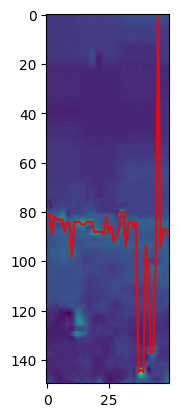

In [96]:
plt.imshow(ROI_trail_1[:150])
plt.plot(gradient_peaks, color='red')


# 

Clearly not the best way to do this

### Trying Canny

In [ ]:
test_image = im1 # ROI_1 # ROI_trail_1[:150] # feed only grayscale images!
window_name = 'Canny Tester'
trackbar_sigma = 'Sigma'
max_sigma = 100
trackbar_kernel = ' Kernel Size'
max_kernel = 201
trackbar_lo_thresh = 'Low'
trackbar_hi_thresh = 'High'
max_value = 255
trackbar_thresh = 'Thresh'

def Canny_Demo(val):

    sigma = cv.getTrackbarPos(trackbar_sigma, window_name)
    kernel = cv.getTrackbarPos(trackbar_kernel, window_name)
    kernel = (int(kernel/2)*2)+1 # ensures kernel is always odd
    lo = cv.getTrackbarPos(trackbar_lo_thresh, window_name)
    hi = cv.getTrackbarPos(trackbar_hi_thresh, window_name)
    thresh_val = cv.getTrackbarPos(trackbar_thresh, window_name)
    _, thresh = cv.threshold(test_image, thresh_val, 255, cv.THRESH_TOZERO)
    blur = cv.GaussianBlur(thresh, (kernel, kernel), sigma)
    canny = cv.Canny(blur, lo, hi)
    cv.imshow(window_name, canny)

cv.namedWindow(window_name)

cv.createTrackbar(trackbar_sigma, window_name, 6, max_sigma, Canny_Demo )
cv.createTrackbar(trackbar_kernel, window_name , 33, max_kernel, Canny_Demo)
cv.createTrackbar(trackbar_lo_thresh, window_name , 7, max_value, Canny_Demo)
cv.createTrackbar(trackbar_hi_thresh, window_name , 7, max_value, Canny_Demo)
cv.createTrackbar(trackbar_thresh, window_name , 40, max_value, Canny_Demo)

# Call the function to initialize
Canny_Demo(0)
# Wait until user finishes program
cv.waitKey()

cv.destroyAllWindows()
for i in range (1,5):
    cv.waitKey(1)

In [90]:
# Function to merge the resized ROI back into the original frame
def merge_roi(frame, roi, x, y):
    frame[y:y+300, x:x+400] = roi
    return frame

vid = cv.VideoCapture('Vids/SIDEVIEW1_20241008-164916506387.webm')
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('output.mp4', fourcc, 30.0, (int(vid.get(3)), int(vid.get(4))), isColor=False)

if (vid.isOpened() == False):
    print("Error opening video stream or file")

while (vid.isOpened()):
    (ret, frame) = vid.read()
    if ret == True:
        # adding normal video view
        clean_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        clean_frame_resized = cv.resize(clean_frame, (400, 300))

        # applying transformations
        frame = cv.GaussianBlur(frame, (61, 61), 19)
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        edge = cv.Canny(frame, 10, 5)

        #merging frames
        frame = merge_roi(edge, clean_frame_resized, 0, 0)

        out.write(edge)
        cv.imshow('Edge Detection', frame)

    else:
        break


    if cv.waitKey(25) & 0xFF == ord('q'):
        break


vid.release()
out.release()

cv.waitKey(1)
cv.destroyAllWindows()
for i in range (1,5):
    cv.waitKey(1)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [ ]:
1,2,8,39